# Importation des packages

In [10]:
!git clone https://github.com/jee51/tabata.git

fatal: destination path 'tabata' already exists and is not an empty directory.


In [19]:
import os
import numpy as np
import pandas as pd
#import tabata as tbt
import matplotlib.pyplot as plt

%matplotlib inline
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from scipy.interpolate import interp1d

from collections import Counter

import DTWok

In [9]:
pip install dtaidistance

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
    --------------------------------------- 0.0/1.0 MB 330.3 kB/s eta 0:00:04
   ------ --------------------------------- 0.2/1.0 MB 2.6 MB/s eta 0:00:01
   ------------ --------------------------- 0.3/1.0 MB 2.6 MB/s eta 0:00:01
   ------------------ --------------------- 0.5/1.0 MB 3.0 MB/s eta 0:00:01
   ------------------------ --------------- 0.6/1.0 MB 3.3 MB/s eta 0:00:01
   ------------------------------ --------- 0.8/1.0 MB 3.2 MB/s eta 0:00:01
   ------------------------------------ --- 0.9/1.0 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------  1.0/1.0 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------  1.0/1.0 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------  1.0/1.0 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------  1.0/1.0 MB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 2.2 MB/s eta 0:00:00
Note: you may nee

In [21]:
# Chargement des données.
datadir = "../Data/cleaned/"
final_file = datadir + "AFL1EB_cleaned_final.h5"
norm_file = datadir + "AFL1EB_normed_alt.h5"

dsc = Opset(final_file)



In [23]:
print(f"Nombre total d'enregistrements : {len(dsc)}")
dsc.plot()

Nombre total d'enregistrements : 47


In [42]:
# Sélection d'un vol de référence basé sur la durée médiane
durations = [(df.index[-1] - df.index[0]).total_seconds() for df in list(dsc)]
median_index = np.argsort(durations)[len(durations) // 2]
reference_id = dsc.records[median_index]

print(f"Vol de référence choisi : {reference_id}")
df_reference = dsc[dsc.records.index(reference_id)]

def synchronize_with_dtw(df_reference, df_target, col="ALT[m]", sakoe_chiba_radius=None):
    ref_sequence = df_reference[col].values
    target_sequence = df_target[col].values

    distance, paths = dtw.warping_paths(
        ref_sequence,
        target_sequence,
        window=sakoe_chiba_radius
    )
    best_path = dtw.best_path(paths)
    
    print(f"Distance DTW : {distance}")
    
    dtwvis.plot_warpingpaths(ref_sequence, target_sequence, paths, best_path)
    plt.title("Correspondances DTW")
    plt.show()

    return df_reference, df_target, best_path

def align_target_to_reference(df_target, df_reference, best_path, col="ALT[m]"):
    aligned_values = []

    target_length = len(df_target)

    for ref_idx in range(len(df_reference)):
        # Trouver les indices de la cible alignés avec cet indice de la référence
        target_indices = [
            tgt_idx for tgt_idx, ref_idx_in_path in best_path 
            if ref_idx_in_path == ref_idx and 0 <= tgt_idx < target_length
        ]
        
        #if target_indices:
            # Si plusieurs indices de la cible correspondent, prendre la moyenne
        #aligned_values.append(df_target[col].iloc[target_indices].mean())
        aligned_values.append(df_target[col].iloc[target_indices].mean())
        #else:
            # Si aucun indice de la cible ne correspond, utiliser une valeur nulle ou interpolée
        #aligned_values.append(None)

    # Créer un DataFrame aligné avec les indices de la référence
    aligned_df = pd.DataFrame({
        col: aligned_values
    }, index=df_reference.index)

    # Interpoler les valeurs manquantes pour conserver une continuité (si nécessaire)
    aligned_df[col] = aligned_df[col].interpolate()

    return aligned_df

def reconstruct_target(aligned_df, original_target, col="ALT[m]"):
    reconstructed_df = original_target.copy()

    reconstructed_df[col] = np.interp(
        np.arange(len(original_target)),
        np.linspace(0, len(original_target) - 1, len(aligned_df)),
        aligned_df[col].values,
    )

    return reconstructed_df

def plot_results(df_reference, df_target, aligned_target_df, reconstructed_target_df, col="ALT[m]"):
    plt.figure(figsize=(8, 6))
    plt.plot(df_reference[col].values, label="Référence", color="blue")
    plt.plot(df_target[col].values, label="Cible Originale", color="orange")
    plt.plot(aligned_target_df[col].values, label="Cible Alignée", color="green")
    plt.plot(reconstructed_target_df[col].values, label="Cible Reconstruite", color="red", linestyle="--")
    plt.xlabel("Index")
    plt.ylabel(col)
    plt.title("Alignement et Reconstruction du Vol")
    plt.legend()
    plt.grid()
    plt.show()


Vol de référence choisi : /record_16


In [32]:
def calculate_sync_error(best_path, df_reference, df_target, col="ALT[m]"):
    """Calcule l'erreur de synchronisation entre la référence et la cible."""
    ref_indices, target_indices = zip(*best_path)
    ref_values = df_reference[col].iloc[list(ref_indices)].values
    target_values = df_target[col].iloc[list(target_indices)].values
    
    sync_error = np.abs(ref_values - target_values).mean()  # Moyenne des écarts absolus
    print(f"Erreur de synchronisation moyenne : {sync_error}")
    return sync_error

def calculate_reconstruction_error(original_target, reconstructed_target, col="ALT[m]"):
    """Calcule l'erreur de reconstruction entre la cible originale et reconstruite."""
    original_values = original_target[col].values
    reconstructed_values = reconstructed_target[col].values
    
    mse = np.mean((original_values - reconstructed_values) ** 2)  # Mean Squared Error
    mae = np.mean(np.abs(original_values - reconstructed_values))  # Mean Absolute Error
    
    print(f"Erreur de reconstruction (MSE) : {mse}")
    print(f"Erreur de reconstruction (MAE) : {mae}")
    return mse, mae
def calculate_compression_dilatation(best_path, ref_length, target_length):
    """Calcule les taux de compression et de dilatation."""
    ref_indices, target_indices = zip(*best_path)
    compression_rate = len(ref_indices) / target_length  # Compression = Référence / Cible
    dilatation_rate = len(target_indices) / ref_length   # Dilatation = Cible / Référence
    
    print(f"Taux de compression (Référence vers Cible) : {compression_rate:.2f}")
    print(f"Taux de dilatation (Cible vers Référence) : {dilatation_rate:.2f}")
    return compression_rate, dilatation_rate

Distance DTW : 112915.08250584049


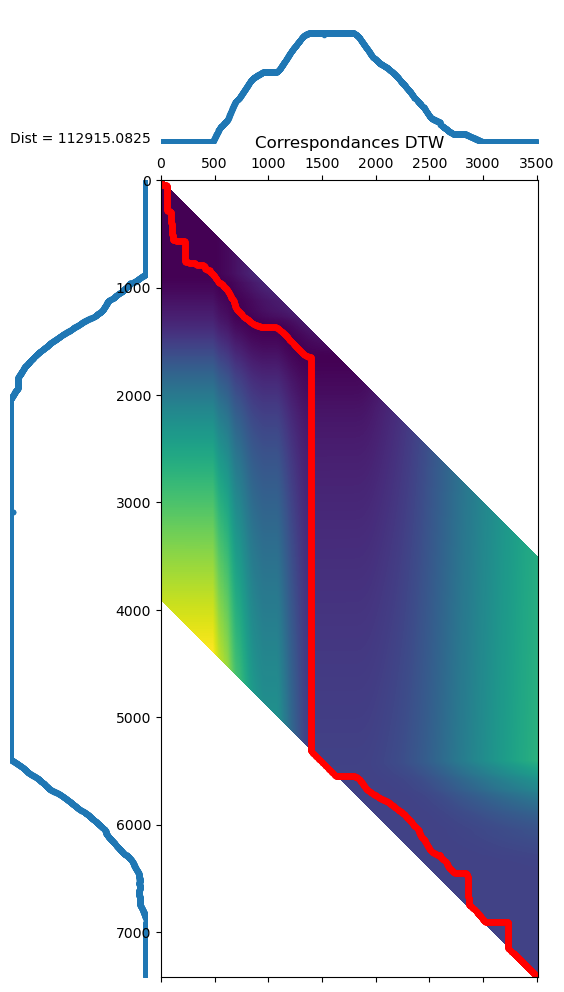

In [43]:

df_reference, df_target, best_path = synchronize_with_dtw(
        df_reference, dsc[5], col="ALT[m]", sakoe_chiba_radius = int(len(df_reference["ALT[m]"]) * 0.001)
)
aligned_target_df = align_target_to_reference(dsc[5], df_reference, best_path, col="ALT[m]")

In [44]:
aligned_target_df.tail(10000)

,ALT[m]
record_16,
2013-02-06 10:26:00,-2.566126
2013-02-06 10:26:01,-1.267968
2013-02-06 10:26:02,-2.535936
2013-02-06 10:26:03,-2.535936
2013-02-06 10:26:04,-2.535936
...,...
2013-02-06 12:29:36,3067.866262
2013-02-06 12:29:37,3067.866262
2013-02-06 12:29:38,3067.866262


Distance DTW : 112915.08250584049


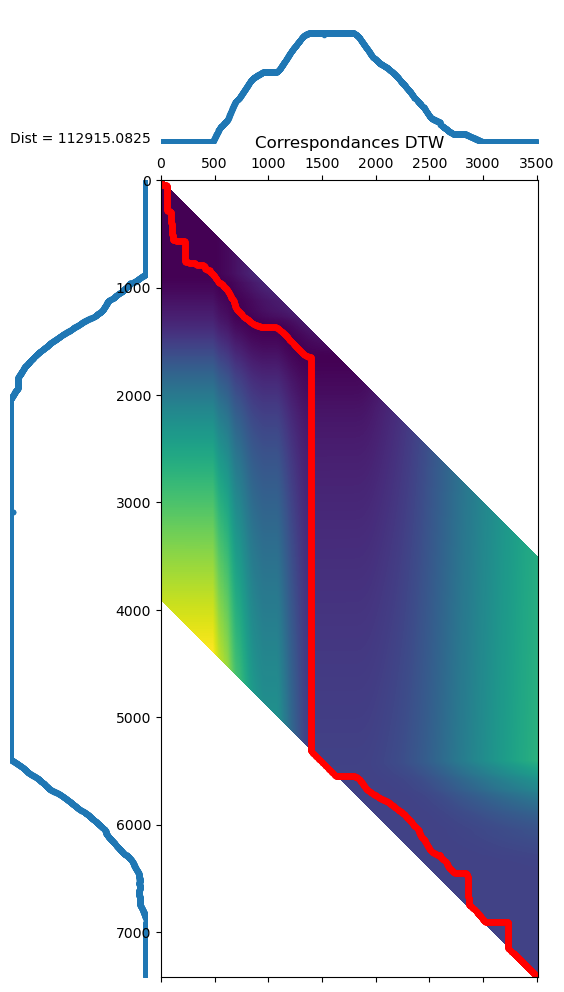

Erreur de synchronisation moyenne : 790.7112027022214
Erreur de reconstruction (MSE) : 18029328.195255797
Erreur de reconstruction (MAE) : 3662.019191686983
Taux de compression (Référence vers Cible) : 2.50
Taux de dilatation (Cible vers Référence) : 1.18


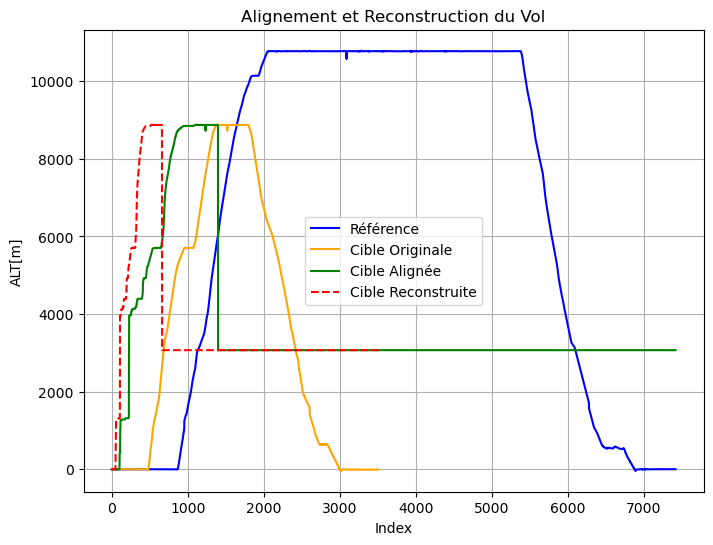

In [46]:
for df_target in [dsc[5]]:
    sakoe_chiba_radius = int(len(df_reference["ALT[m]"]) * 0.001)
    
    # Synchronisation avec DTW
    df_reference, df_target, best_path = synchronize_with_dtw(
        df_reference, df_target, col="ALT[m]", sakoe_chiba_radius=sakoe_chiba_radius
    )
    
    # Alignement et reconstruction
    aligned_target_df = align_target_to_reference(df_target, df_reference, best_path, col="ALT[m]")
    reconstructed_target_df = reconstruct_target(aligned_target_df, df_target, col="ALT[m]")
    
    # Calcul des erreurs
    sync_error = calculate_sync_error(best_path, df_reference, df_target, col="ALT[m]")
    mse, mae = calculate_reconstruction_error(df_target, reconstructed_target_df, col="ALT[m]")
    compression_rate, dilatation_rate = calculate_compression_dilatation(best_path,len(df_reference), len(df_target))
    
    # Visualisation
    plot_results(df_reference, df_target, aligned_target_df, reconstructed_target_df, col="ALT[m]")
